In [58]:
from santa_fe_2 import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numba import njit
from scipy.optimize import curve_fit
import pandas as pd
import statsmodels.api as sm
import scipy.stats


@njit()
def compute_price_impact(price,sign,max_lag,step=1):
    impact = []
    for i in range(1,max_lag,step):
        impact.append((-sign[:-i]*(price[i:]-price[:-i])).mean())
    
    return impact

@njit()
def compute_diffusion_rate(vol_size,array, min_val = 1):
    variance = np.zeros(vol_size - min_val + 1)
    for i in range(min_val, vol_size+1):
        variance[i - min_val] = (array[i:]-array[:-i]).var()
        
    return variance

@njit()
def compute_volatility(vol_size,array):
    sigma = np.zeros(vol_size)
    for i in range(1,vol_size+1):
        #new_arr = ((array[i:]-array[:-i])**2).mean()
        #sigma[i] = np.sqrt((new_arr/array.mean()**2))
        sigma[i] = array[::i].std()
    return sigma

@njit()
def compute_volatility_1(vol_size,array):
    sigma = np.zeros(vol_size)
    for i in range(1,vol_size+1):
        new_arr = (array[i:]-array[:-i])**2
        sigma[i] = new_arr.sum()/i
    return sigma

def avg(lst):
    return np.array(lst).mean()

def func(x, m, q):
    return m * x + q

def find_param(xx,yy):
    popt, pcov = curve_fit(func, xx, yy)
    m = popt[0]
    q = popt[1]
    err_m = np.sqrt(pcov[0][0])
    err_q = np.sqrt(pcov[1][1])

    
    return m, q, err_m, err_q

def func(x,x0,gamma):
    return x0*x+gamma

def func2(x,x0,gamma):
    return x0*x**gamma

def find_param_vol(xx,yy,x0=10e-5,gamma=1):
    popt, pcov = curve_fit(func2, xx, yy,p0=(x0,gamma))
    xx0 = popt[0]
    gamma0 = popt[1]
    return xx0,gamma0

@njit()
def compute_price_impact(price,sign,max_lag,step=1):
    impact = []
    std_impact = []
    for i in range(1,max_lag,step):
        impact.append((sign[:-i]*(price[i:]-price[:-i])).mean())
        std_impact.append((sign[:-i]*(price[i:]-price[:-i])).std() / np.sqrt(len(price[i:])))
    
    return impact, std_impact
    
plt.style.use('dark_background')

# Lob Small tick stock

Per prezzi lontani dal mid price il LOB raggiunge uno stato stazionario, il livello di occupazione per un prezzo segue la distribuzione:

$e^{-V^{\star}}\frac{(V^{\star})^V}{V!}, \quad \quad V^{\star} = \lambda/\delta $

In particolare ci aspettiamo quindi che per una small tick stock la forma del LOB sia sparsa, mentre ci aspettiamo che sia densa per big tick stock.

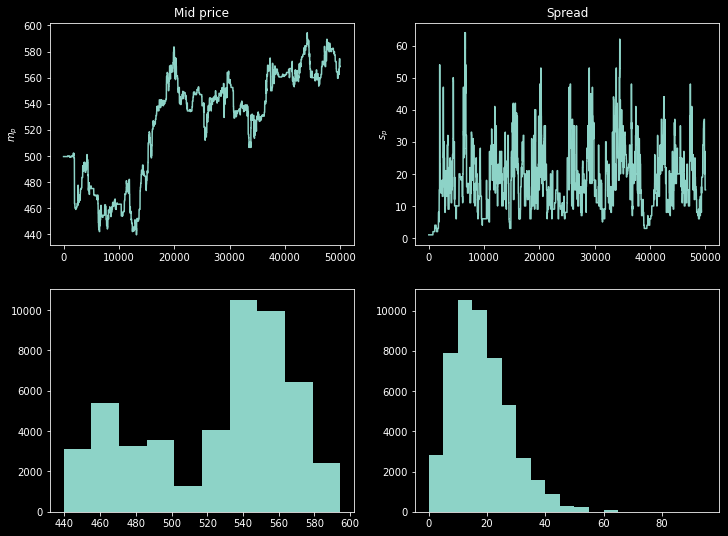

17.54824


In [2]:
rate_lim = 0.018 
rate_m   = 0.055 
rate_del = 0.107



lob, order, typ, pric  = simulate_lob(rate_lim, rate_m, rate_del,1000,50_000)

md, sp = find_mid_spread_lob(lob)

fig,ax = plt.subplots(2,2,figsize = (12,9))

ax[0,0].plot(md)
ax[0,0].set_ylabel(r"$m_p$")
ax[0,0].set_title("Mid price")
ax[1,0].hist(md)
ax[0,1].plot(sp)
ax[0,1].set_ylabel(r"$s_p$")
ax[0,1].set_title("Spread")
ax[1,1].hist(sp,bins=np.arange(0,100,5))

plt.show()
print(sp.mean())

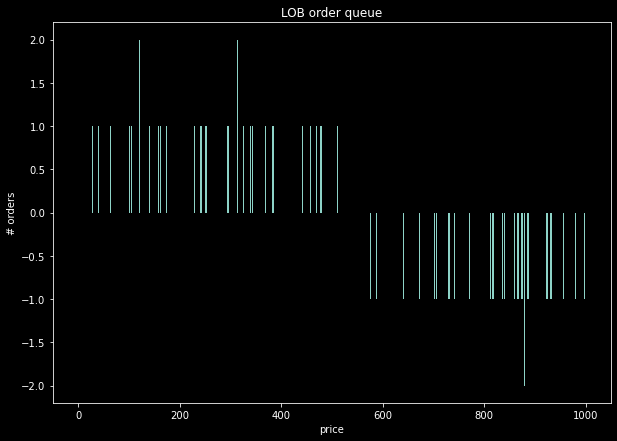

In [4]:
fig,ax = plt.subplots(1,1,figsize = (10,7))
plt.bar(np.arange(1000),lob[-1])
plt.title("LOB order queue")
plt.ylabel("# orders")
plt.xlabel("price")
plt.show()

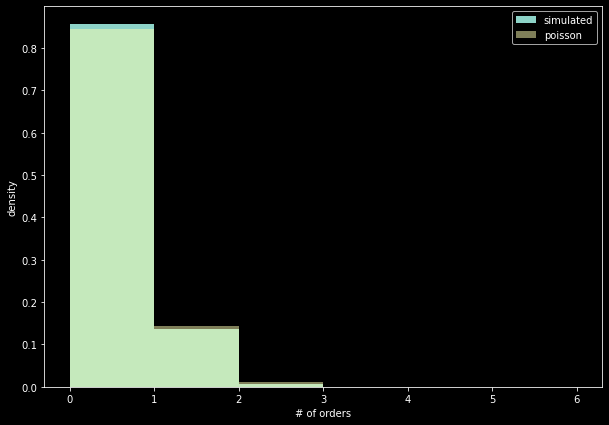

In [8]:
fig,ax = plt.subplots(1,1,figsize = (10,7))
plt.hist(np.abs(lob[-1]), density = True, bins=np.arange(0,7), label="simulated")

ps = scipy.stats.poisson.rvs(rate_lim/rate_del, size=1000000)
plt.hist(ps,density = True, bins=np.arange(0,7), alpha = 0.50, label="poisson")
plt.xlabel("# of orders")
plt.ylabel("density")
plt.legend()
plt.show()

# Lob large tick stock

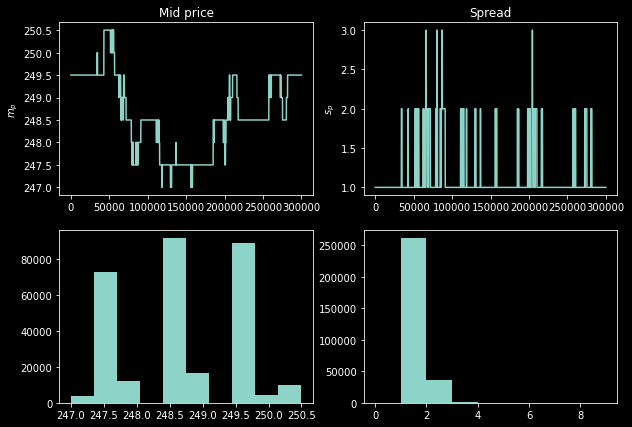

1.1322266666666667


In [9]:
rate_lim = 0.169
rate_m   = 0.031
rate_del = 0.041



lob, order, typ, pric  = simulate_lob(rate_lim, rate_m, rate_del,500,300_000)

md, sp = find_mid_spread_lob(lob)

fig,ax = plt.subplots(2,2,figsize = (10,7))

ax[0,0].plot(md)
ax[0,0].set_ylabel(r"$m_p$")
ax[0,0].set_title("Mid price")
ax[1,0].hist(md)
ax[0,1].plot(sp)
ax[0,1].set_ylabel(r"$s_p$")
ax[0,1].set_title("Spread")
ax[1,1].hist(sp,bins=np.arange(0,10))

plt.show()
print(sp.mean())

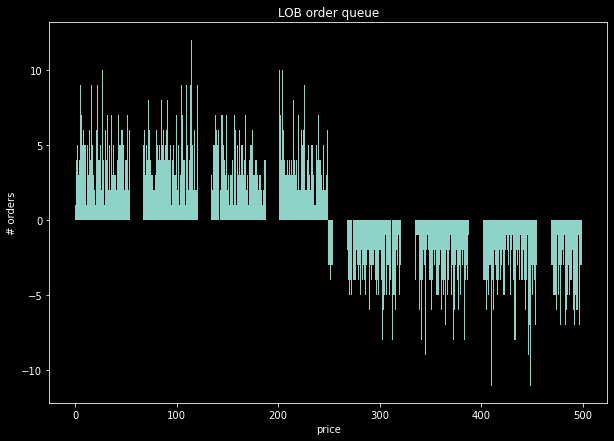

In [10]:
fig,ax = plt.subplots(1,1,figsize = (10,7))
plt.bar(np.arange(500),lob[-1])
plt.title("LOB order queue")
plt.ylabel("# orders")
plt.xlabel("price")
plt.show()

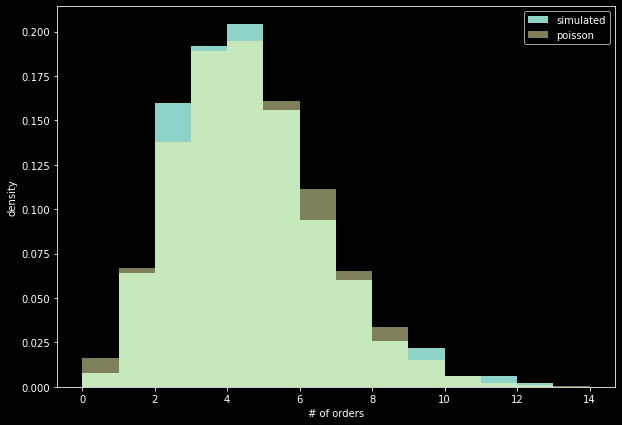

In [11]:
fig,ax = plt.subplots(1,1,figsize = (10,7))
plt.hist(np.abs(lob[-1]), density = True, bins=np.arange(0,15), label="simulated")
ps = scipy.stats.poisson.rvs(rate_lim/rate_del, size=1000000)
plt.hist(ps,density = True, bins=np.arange(0,15), alpha = 0.50, label="poisson")
plt.xlabel("# of orders")
plt.ylabel("density")
plt.legend()
plt.show()

# Mid spread

Abbiamo che esiste una relazione di scaling che lega $\lambda$ , $\mu$ , $\nu$ allo spread medio.

Infatti abbiamo che:
$<s> = \frac{\mu}{\lambda} F(\frac{\delta}{\mu}) $

con F(u) che vale:

$F(u) \sim 0.28 + 1.86 u^{3/4}$

Voglio verificare adesso questa relazione di scaling

In [12]:
mean_sp = np.zeros(15)
std_sp  = np.zeros(15)
rates = np.linspace(1, 5 ,15)

monte_sp = np.zeros(8)

for k in range(15):
    print(k, end= "\r")
    
    rate_lim = 1/rates[k]
    rate_m   = 1
    rate_del = 0
    
    for i in range(8):
        lob, order, typ, pric = simulate_lob(rate_lim, rate_m, rate_del, 400 ,300_000)
        md, sp = find_mid_spread_lob(lob)
        
        monte_sp[i] = sp.mean()
        
    mean_sp[k] = monte_sp.mean()

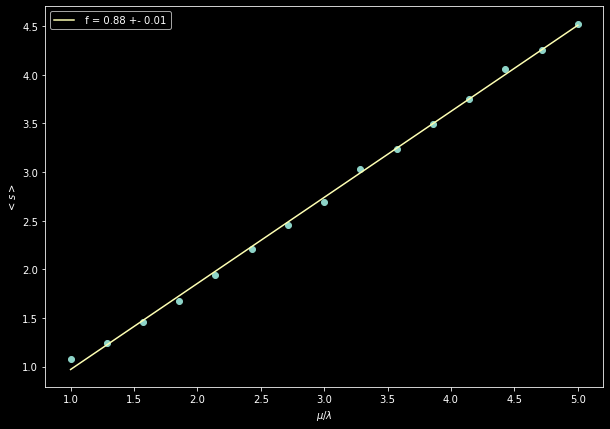

In [14]:
fig,ax = plt.subplots(1,1,figsize = (10,7))
plt.errorbar(x = rates, y = mean_sp, ls="", marker="o",zorder=2)
m,q,dm,dq = find_param(rates, mean_sp)

plt.plot(rates,func(rates,m,q), zorder= 3, label = f" f = {m:.2f} +- {dm:.2f}")
plt.xlabel(r"$\mu/\lambda$")
plt.ylabel(r"$<s>$")
plt.legend()
plt.show()

# Diffusion rate

Il diffusion rate è la pendenza di:

$var(m_{t + \tau} - m_{t})$

Quello che si osserva è che per il modello zero intelligence esistono due scali temporali differenti.

Per $\tau$ $\to$ 0 abbiamo una diffusione più veloce, mentre nel mimite $\tau \to \infty$ abbiamo una diffusione più lenta.

In [37]:
rate_lim = 1.5
rate_m   = 2
rate_del = 0.3
    
lob, order, typ, pric = simulate_lob(rate_lim, rate_m, rate_del, 500, 1_000_000)
md, sp = find_mid_spread_lob(lob)
  
m_price = np.log(md)

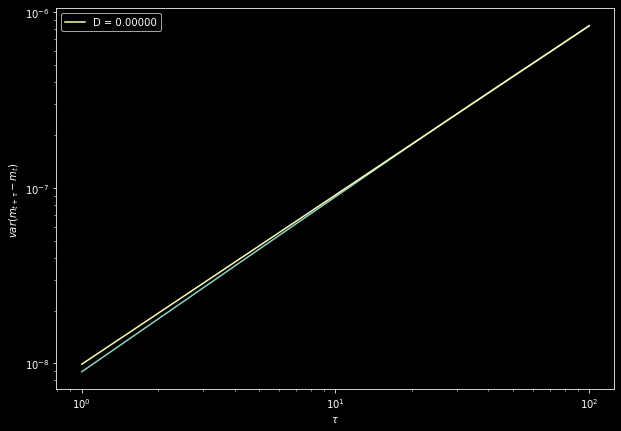

0.9737289911202953
9.900865574863901e-09 0.9635279037827355


In [38]:
volatility = compute_diffusion_rate(100,m_price)
fig,ax = plt.subplots(1,1,figsize = (10,7))
x = np.arange(1,101)
plt.loglog()
plt.plot(x,volatility)

a0,k0 = find_param_vol(x,volatility)

plt.plot(x,func2(x,a0,k0),label=f"D = {a0:.5f}")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$var(m_{t + \tau} - m_{t})$")

plt.legend()

plt.show()

eps = 2 * rate_del / rate_m
theory = rate_m**2 * rate_del / rate_lim**2 * eps**(-0.5)
print(theory)
print(a0,k0)

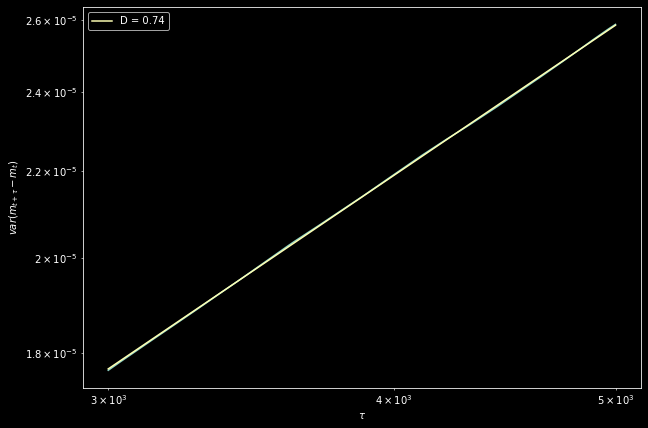

0.2921186973360886


In [32]:
fig,ax = plt.subplots(1,1,figsize = (10,7))
volatility = compute_diffusion_rate(5000,m_price,3001)
x = np.arange(3000,5000)
plt.loglog()
plt.plot(x,volatility)

plt.xlabel(r"$\tau$")
plt.ylabel(r"$var(m_{t + \tau} - m_{t})$")

a0,k0 = find_param_vol(x,volatility)

plt.plot(x,func2(x,a0,k0),label=f"D = {k0:.2f}")
plt.legend()

plt.show()

eps = 2 * rate_del / rate_m
theory = rate_m**2 * rate_del / rate_lim**2 * eps**(0.5)
print(theory)

# Market impact

In [64]:
rate_lim = 0.018 
rate_m   = 0.055 
rate_del = 0.107

lob, o_type, sign, price = simulate_lob(rate_lim, rate_m, rate_del, 8000,1000_000)
md, sp = find_mid_spread_lob(lob)


In [65]:
stats = dict()
stats["order type"] = np.array(o_type)
stats["price"] = np.array(price)
stats["direction"] = np.array(sign)
stats["spread"] = sp[:-1]
stats["mid price"] = md[:-1]
df = pd.DataFrame(stats)
df.drop(labels = 0, axis = 0, inplace = True)
market_df = df[df["order type"] == 1]
market_orders = market_df.index.to_numpy() - 2
sign_orders = market_df["direction"].to_numpy()
new_df = df.iloc[market_orders]
mid_p = new_df["mid price"].to_numpy()
p_impact, std_p = compute_price_impact(mid_p,sign_orders,200)

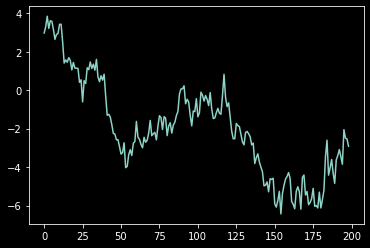

In [66]:
plt.plot(p_impact)

TypeError: list indices must be integers or slices, not tuple

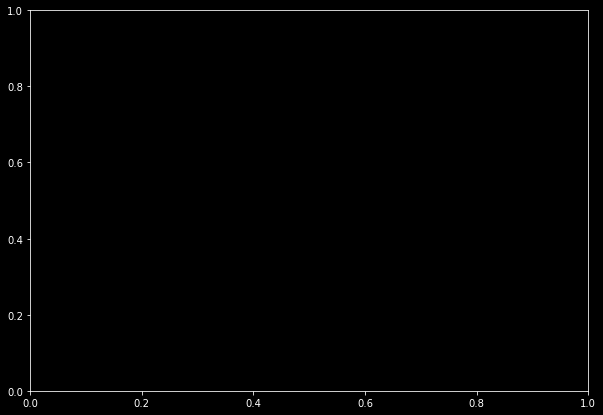

In [39]:
p_mean = np.zeros(499)
fig,ax = plt.subplots(1,1,figsize = (10,7))
for i in range(499):
    p_mean[i] = p_impact[:,i].mean()

plt.ylabel("Impact")
plt.xlabel(r"$\tau$")
plt.plot(p_mean)
plt.ylim(-5,6)


# autocorrelation

In [35]:
corr = np.zeros(100)
for i in range(100):
    corr[i] = market_df["direction"].autocorr(i)

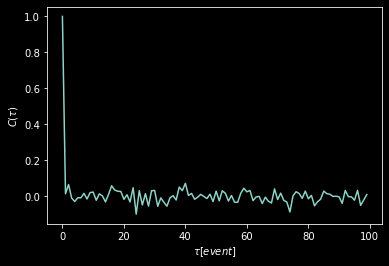

In [36]:
plt.plot(corr)

plt.ylabel(r"$C(\tau)$")
plt.xlabel(r"$\tau [event]$")

plt.show()